<center><h1 style="font-size:3em"> Few-shot text classification </h1></center>
<br>
<center><i style="font-size:1.3em">With a Deep Learning Approach</i></center>

Resources :
- Includes Easy Data Augmentation (EDA) package : https://github.com/jasonwei20/eda_nlp/blob/master/code/eda.py introduced after this paper : https://arxiv.org/pdf/1901.11196.pdf
- Neural Structure Learning for sentiment classification (learn graph from embedding) : https://www.tensorflow.org/neural_structured_learning/tutorials/graph_keras_lstm_imdb
- RNN text classification with Tensorflow 2.0 : https://www.tensorflow.org/beta/tutorials/text/text_classification_rnn
- Great paper from August 2019 : https://arxiv.org/pdf/1908.08788.pdf


In [118]:
import pandas as pd
import numpy as np
from random import seed
from random import sample
import random
from random import shuffle
import re

seed(42)
np.random.seed(42)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import gensim.downloader as api
from gensim.models.keyedvectors import Word2VecKeyedVectors

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy import spatial

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet 

import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow.keras
import tensorflow.keras.preprocessing.text as kpt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

import neural_structured_learning as nsl
import tensorflow_hub as hub

In [105]:
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
'ours', 'ourselves', 'you', 'your', 'yours', 
'yourself', 'yourselves', 'he', 'him', 'his', 
'himself', 'she', 'her', 'hers', 'herself', 
'it', 'its', 'itself', 'they', 'them', 'their', 
'theirs', 'themselves', 'what', 'which', 'who', 
'whom', 'this', 'that', 'these', 'those', 'am', 
'is', 'are', 'was', 'were', 'be', 'been', 'being', 
'have', 'has', 'had', 'having', 'do', 'does', 'did',
'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
'because', 'as', 'until', 'while', 'of', 'at', 
'by', 'for', 'with', 'about', 'against', 'between',
'into', 'through', 'during', 'before', 'after', 
'above', 'below', 'to', 'from', 'up', 'down', 'in',
'out', 'on', 'off', 'over', 'under', 'again', 
'further', 'then', 'once', 'here', 'there', 'when', 
'where', 'why', 'how', 'all', 'any', 'both', 'each', 
'few', 'more', 'most', 'other', 'some', 'such', 'no', 
'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
'very', 's', 't', 'can', 'will', 'just', 'don', 
'should', 'now', '']

In [106]:
#model2 = api.load('glove-twitter-25')
model2 = api.load('word2vec-google-news-300')

# Load the data

The dataset comes from Stackoverflow Short Text Classification : https://github.com/jacoxu/StackOverflow

In [79]:
df = pd.read_csv("stack.csv")

In [80]:
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

In [81]:
df['Text'] = df['Text'].apply(lambda x: get_only_chars(x))

In [82]:
df.head()

,Text,Label
0,how do i fill a dataset or a datatable from a ...,18
1,how do you page a collection with linq,18
2,best subversion clients for windows vista bit,3
3,best practice collaborative environment bin di...,3
4,visual studio setup project per user registry ...,7


# Prepare the data

In [83]:
num_classes = 2
sample_size = 50

In [84]:
# Generate samples that contains K samples of each class

def gen_sample(sample_size, num_classes):
    
    df_1 = df[(df["Label"]<num_classes + 1)].reset_index().drop(["index"], axis=1).reset_index().drop(["index"], axis=1)
    train = df_1[df_1["Label"] == np.unique(df_1['Label'])[0]].sample(sample_size)
    
    train_index = train.index.tolist()
    
    for i in range(1,num_classes):
        train_2 = df_1[df_1["Label"] == np.unique(df_1['Label'])[i]].sample(sample_size)
        train = pd.concat([train, train_2], axis=0)
        train_index.extend(train_2.index.tolist())
        
    test = df_1[~df_1.index.isin(train_index)]

    return train, test

In [85]:
# Text processing (split, find token id, get embedidng)

def transform_sentence(text, model):
    
    """
    Mean embedding vector
    """
    
    def preprocess_text(raw_text, model=model):
        
        """ 
        Eexcluding unknown words and get corresponding token
        """
        
        raw_text = raw_text.split()
        
        return list(filter(lambda x: x in model.vocab, raw_text))
    
    tokens = preprocess_text(text)
    
    if not tokens:
        return np.zeros(model.vector_size)

    text_vector = np.mean(model[tokens], axis=0)
    
    return np.array(text_vector)

In [86]:
train, test = gen_sample(sample_size, num_classes)

In [87]:
train

,Text,Label
1521,how to get wordpress page id after looping posts,1
1737,using wp query to pull content from a specific...,1
1740,wordpress how to show just posts on main index,1
1660,wordpress is it possible to make one particula...,1
1411,exclude templates in wordpress page,1
1678,wierd date and time formating in wordpress y m d,1
1626,wordpress custom post type templates,1
1513,inserting wordpress plugin content to posts,1
1859,how can i delay one feed in wordpress but not ...,1
1072,how can i remove jquery from the frontside of ...,1


In [88]:
train.shape

(100, 2)

In [89]:
X_train = train['Text']
y_train = train['Label'].values
X_test = test['Text']
y_test = test['Label'].values

X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

# Data Augmentation

## Replace words

In [90]:
def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            #print("replaced", random_word, "with", synonym)
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

def iterative_replace(df):
    
    df = df.reset_index().drop(['index'], axis=1)
    index_row = df.index
    df_2 = pd.DataFrame()
    
    for row in index_row:
        for k in range(1,6):
            df_2 = df_2.append({'Text':synonym_replacement(df.loc[row]['Text'], k), 'Label':df.loc[row]['Label']}, ignore_index=True)
    return df_2

## Delete words

In [91]:
def random_deletion(words, p):

    words = words.split()
    
    #obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    #randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    #if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    
    return sentence

def iterative_delete(df):
    
    df = df.reset_index().drop(['index'], axis=1)
    index_row = df.index
    df_2 = pd.DataFrame()
    
    for row in index_row:
        df_2 = df_2.append({'Text':random_deletion(df.loc[row]['Text'], 0.25), 'Label':df.loc[row]['Label']}, ignore_index=True)
    return df_2

## Random Swap

In [92]:
def random_swap(words, n):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        new_words = swap_word(new_words)
        
    sentence = ' '.join(new_words)
    
    return sentence

def swap_word(new_words):
    
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        
        if counter > 3:
            return new_words
    
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

def iterative_swap(df):
    
    df = df.reset_index().drop(['index'], axis=1)
    index_row = df.index
    df_2 = pd.DataFrame()
    for row in index_row:
        df_2 = df_2.append({'Text':random_swap(df.loc[row]['Text'], 2), 'Label':df.loc[row]['Label']}, ignore_index=True)
    return df_2

## Random Insertion

In [93]:
def random_insertion(words, n):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
        
    sentence = ' '.join(new_words)
    return sentence

def add_word(new_words):
    
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
        
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)
    
def iterative_insert(df):
    
    df = df.reset_index().drop(['index'], axis=1)
    index_row = df.index
    df_2 = pd.DataFrame()
    
    for row in index_row:
        df_2 = df_2.append({'Text':random_insertion(df.loc[row]['Text'], 2), 'Label':df.loc[row]['Label']}, ignore_index=True)
        
    return df_2

## Data Augmentation

In [94]:
df_replace = iterative_replace(train)
df_delete = iterative_delete(train)
df_swap = iterative_swap(train)
df_insert = iterative_insert(train)

train = pd.concat([train, df_replace, df_delete, df_swap, df_insert], axis=0).reset_index().drop(['index'], axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [95]:
X_train = train['Text']
y_train = train['Label'].values
X_test = test['Text']
y_test = test['Label'].values

X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

# DL Pipeline

In [110]:
def whole_pipeline(sample_size, num_classes=2):
    
    train, test = gen_sample(sample_size, num_classes)
    
    df_replace = iterative_replace(train)
    df_delete = iterative_delete(train)
    df_swap = iterative_swap(train)
    df_insert = iterative_insert(train)

    train = pd.concat([train, df_replace, df_delete, df_swap, df_insert], axis=0).reset_index().drop(['index'], axis=1)
    
    X_train = train['Text']
    y_train = train['Label'].values
    X_test = test['Text']
    y_test = test['Label'].values
    
    max_words = 1000
    max_len = 1000
    tok = Tokenizer(num_words=max_words)
    tok.fit_on_texts(train.Text)
    
    sequences = tok.texts_to_sequences(X_train)
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
    
    def build_base_model():
    
        """
        Builds a model according to the architecture defined in `hparams`.
        """

        model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_len, 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        return model

    model = build_base_model()

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    history = model.fit(sequences_matrix, y_train-1, validation_split=0.2, batch_size=16, epochs=5)

    test_sequences = tok.texts_to_sequences(test.Text)
    test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
    
    y_pred = model.predict(test_sequences_matrix)
    
    return accuracy_score(np.round(y_pred), test['Label']-1)

In [111]:
accuracy_deep = []

for num_sample in [3, 5, 10, 20, 50, 100]:
    accuracy_deep.append(whole_pipeline(num_sample))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


Train on 43 samples, validate on 11 samples
Epoch 1/5
43/43 [==============================] - 6s 138ms/sample - loss: 0.6900 - accuracy: 0.7209 - val_loss: 0.6821 - val_accuracy: 1.0000
Epoch 2/5
43/43 [==============================] - 2s 47ms/sample - loss: 0.6792 - accuracy: 0.9535 - val_loss: 0.6699 - val_accuracy: 1.0000
Epoch 3/5
43/43 [==============================] - 2s 47ms/sample - loss: 0.6665 - accuracy: 0.9767 - val_loss: 0.6522 - val_accuracy: 1.0000
Epoch 4/5
43/43 [==============================] - 2s 53ms/sample - loss: 0.6464 - accuracy: 1.0000 - val_loss: 0.6259 - val_accuracy: 1.0000
Epoch 5/5
43/43 [==============================] - 3s 63ms/sample - loss: 0.6151 - accuracy: 1.0000 - val_loss: 0.5813 - val_accuracy: 1.0000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


Train on 72 samples, validate on 18 samples
Epoch 1/5
72/72 [==============================] - 9s 123ms/sample - loss: 0.6922 - accuracy: 0.4583 - val_loss: 0.6856 - val_accuracy: 0.9444
Epoch 2/5
72/72 [==============================] - 4s 60ms/sample - loss: 0.6814 - accuracy: 0.6528 - val_loss: 0.6774 - val_accuracy: 0.4444
Epoch 3/5
72/72 [==============================] - 4s 56ms/sample - loss: 0.6641 - accuracy: 0.5833 - val_loss: 0.6515 - val_accuracy: 0.7778
Epoch 4/5
72/72 [==============================] - 3s 48ms/sample - loss: 0.6315 - accuracy: 0.7639 - val_loss: 0.5975 - val_accuracy: 0.8889
Epoch 5/5
72/72 [==============================] - 3s 45ms/sample - loss: 0.5584 - accuracy: 0.9028 - val_loss: 0.4904 - val_accuracy: 1.0000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


Train on 144 samples, validate on 36 samples
Epoch 1/5
144/144 [==============================] - 12s 80ms/sample - loss: 0.6851 - accuracy: 0.5486 - val_loss: 0.6735 - val_accuracy: 0.5278
Epoch 2/5
144/144 [==============================] - 7s 50ms/sample - loss: 0.6467 - accuracy: 0.7569 - val_loss: 0.6080 - val_accuracy: 0.7500
Epoch 3/5
144/144 [==============================] - 7s 51ms/sample - loss: 0.5331 - accuracy: 0.8542 - val_loss: 0.3989 - val_accuracy: 1.0000
Epoch 4/5
144/144 [==============================] - 8s 57ms/sample - loss: 0.3133 - accuracy: 0.9653 - val_loss: 0.1516 - val_accuracy: 1.0000
Epoch 5/5
144/144 [==============================] - 7s 46ms/sample - loss: 0.1079 - accuracy: 0.9931 - val_loss: 0.0321 - val_accuracy: 1.0000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


Train on 288 samples, validate on 72 samples
Epoch 1/5
288/288 [==============================] - 16s 56ms/sample - loss: 0.6908 - accuracy: 0.4896 - val_loss: 0.6767 - val_accuracy: 0.5694
Epoch 2/5
288/288 [==============================] - 15s 53ms/sample - loss: 0.6095 - accuracy: 0.9618 - val_loss: 0.4548 - val_accuracy: 0.8889
Epoch 3/5
288/288 [==============================] - 12s 41ms/sample - loss: 0.2920 - accuracy: 0.9306 - val_loss: 0.0403 - val_accuracy: 1.0000
Epoch 4/5
288/288 [==============================] - 11s 39ms/sample - loss: 0.0783 - accuracy: 1.0000 - val_loss: 0.0313 - val_accuracy: 1.0000
Epoch 5/5
288/288 [==============================] - 11s 40ms/sample - loss: 0.0266 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 1.0000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


Train on 720 samples, validate on 180 samples
Epoch 1/5
720/720 [==============================] - 40s 55ms/sample - loss: 0.6168 - accuracy: 0.7181 - val_loss: 0.2286 - val_accuracy: 0.9944
Epoch 2/5
720/720 [==============================] - 33s 46ms/sample - loss: 0.1170 - accuracy: 0.9875 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 3/5
720/720 [==============================] - 33s 45ms/sample - loss: 0.0103 - accuracy: 0.9986 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 4/5
720/720 [==============================] - 32s 44ms/sample - loss: 0.0046 - accuracy: 0.9986 - val_loss: 7.2666e-04 - val_accuracy: 1.0000
Epoch 5/5
720/720 [==============================] - 33s 46ms/sample - loss: 0.0036 - accuracy: 1.0000 - val_loss: 8.5259e-04 - val_accuracy: 1.0000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


Train on 1440 samples, validate on 360 samples
Epoch 1/5
1440/1440 [==============================] - 72s 50ms/sample - loss: 0.4006 - accuracy: 0.8299 - val_loss: 0.0575 - val_accuracy: 0.9917
Epoch 2/5
1440/1440 [==============================] - 61s 42ms/sample - loss: 0.0265 - accuracy: 0.9958 - val_loss: 0.0101 - val_accuracy: 0.9972
Epoch 3/5
1440/1440 [==============================] - 59s 41ms/sample - loss: 0.0073 - accuracy: 0.9986 - val_loss: 0.0075 - val_accuracy: 0.9972
Epoch 4/5
1440/1440 [==============================] - 62s 43ms/sample - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.0062 - val_accuracy: 0.9972
Epoch 5/5
1440/1440 [==============================] - 67s 46ms/sample - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0062 - val_accuracy: 0.9972


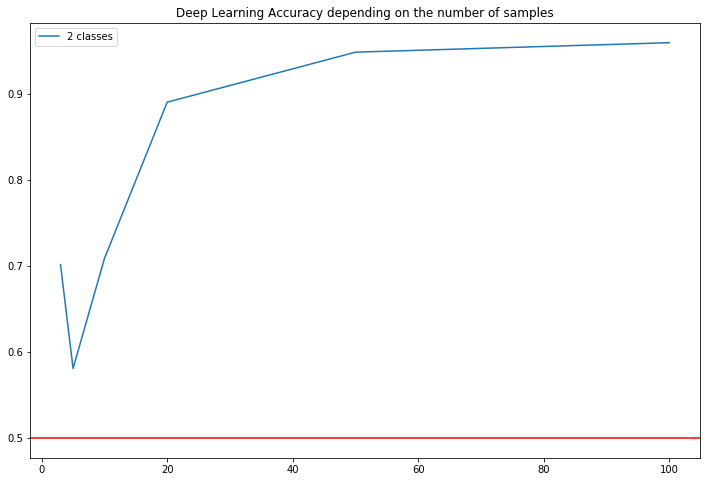

In [116]:
plt.figure(figsize=(12,8))
plt.plot([3, 5, 10, 20, 50, 100], accuracy_deep, label="2 classes")
plt.title("Deep Learning Accuracy depending on the number of samples")
plt.axhline(0.5, c='r')
plt.legend()
plt.show()

# Neural Structured Learning

In [119]:
tf.compat.v1.enable_v2_behavior()

# Resets notebook state
tf.keras.backend.clear_session()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-rc0
Eager mode:  True
Hub version:  0.3.0
GPU is NOT AVAILABLE


In [120]:
imdb = tf.keras.datasets.imdb
(pp_train_data, pp_train_labels), (pp_test_data, pp_test_labels) = (
    imdb.load_data(num_words=10000))

In [121]:
print('Training entries: {}, labels: {}'.format(
    len(pp_train_data), len(pp_train_labels)))
training_samples_count = len(pp_train_data)

Training entries: 25000, labels: 25000


In [122]:
def build_reverse_word_index():
    # A dictionary mapping words to an integer index
    word_index = imdb.get_word_index()

    # The first indices are reserved
    word_index = {k: (v + 3) for k, v in word_index.items()}
    word_index['<PAD>'] = 0
    word_index['<START>'] = 1
    word_index['<UNK>'] = 2  # unknown
    word_index['<UNUSED>'] = 3
    return dict((value, key) for (key, value) in word_index.items())

reverse_word_index = build_reverse_word_index()

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [123]:
!mkdir -p /tmp/imdb

In [124]:
tf.compat.v1.disable_tensor_equality()

pretrained_embedding = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1'

hub_layer = hub.KerasLayer(
    pretrained_embedding, input_shape=[], dtype=tf.string, trainable=True)

In [125]:
def _int64_feature(value):
    """Returns int64 tf.train.Feature."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value.tolist()))


def _bytes_feature(value):
    """Returns bytes tf.train.Feature."""
    return tf.train.Feature(
      bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))


def _float_feature(value):
    """Returns float tf.train.Feature."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value.tolist()))


def create_embedding_example(word_vector, record_id):
    """Create tf.Example containing the sample's embedding and its ID."""

    text = decode_review(word_vector)

    # Shape = [batch_size,].
    sentence_embedding = hub_layer(tf.reshape(text, shape=[-1,]))

     # Flatten the sentence embedding back to 1-D.
    sentence_embedding = tf.reshape(sentence_embedding, shape=[-1])

    features = {
      'id': _bytes_feature(str(record_id)),
      'embedding': _float_feature(sentence_embedding.numpy())
    }
    return tf.train.Example(features=tf.train.Features(feature=features))


def create_embeddings(word_vectors, output_path, starting_record_id):
    record_id = int(starting_record_id)
    with tf.io.TFRecordWriter(output_path) as writer:
        for word_vector in word_vectors:
            example = create_embedding_example(word_vector, record_id)
            record_id = record_id + 1
            writer.write(example.SerializeToString())
    return record_id


# Persist TF.Example features containing embeddings for training data in
# TFRecord format.
create_embeddings(pp_train_data, '/tmp/imdb/embeddings.tfr', 0)

25000

In [126]:
!python -m neural_structured_learning.tools.build_graph \
--similarity_threshold=0.99 /tmp/imdb/embeddings.tfr /tmp/imdb/graph_99.tsv

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.21.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
/anaconda3/lib/python3.6/runpy.py:125: RuntimeWarning: 'neural_structured_learning.tools.build_graph' found in sys.modules after import of package 'neural_structured_learning.tools', but prior to execution of 'neural_structured_learning.tools.build_graph'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Reading tf.train.Examples from TFRecord file: /tmp/imdb/embeddings.tfr...
2019-09-09 17:26:44.655803: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports inst

In [128]:
!python -m neural_structured_learning.tools.pack_nbrs \
--max_nbrs=3 --add_undirected_edges=True \
/tmp/imdb/train_data.tfr '' /tmp/imdb/graph_99.tsv \
/tmp/imdb/nsl_train_data.tfr

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.21.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
/anaconda3/lib/python3.6/runpy.py:125: RuntimeWarning: 'neural_structured_learning.tools.pack_nbrs' found in sys.modules after import of package 'neural_structured_learning.tools', but prior to execution of 'neural_structured_learning.tools.pack_nbrs'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Reading tf.train.Examples from TFRecord file: /tmp/imdb/train_data.tfr...
2019-09-09 17:39:14.957573: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instruct

In [129]:
NBR_FEATURE_PREFIX = 'NL_nbr_'
NBR_WEIGHT_SUFFIX = '_weight'

In [130]:
class HParams(object):
    """Hyperparameters used for training."""
    def __init__(self):
        ### dataset parameters
        self.num_classes = 2
        self.max_seq_length = 256
        self.vocab_size = 10000
        ### neural graph learning parameters
        self.distance_type = nsl.configs.DistanceType.L2
        self.graph_regularization_multiplier = 0.1
        self.num_neighbors = 2
        ### model architecture
        self.num_embedding_dims = 16
        self.num_lstm_dims = 64
        self.num_fc_units = 64
        ### training parameters
        self.train_epochs = 10
        self.batch_size = 128
        ### eval parameters
        self.eval_steps = None  # All instances in the test set are evaluated.

HPARAMS = HParams()

In [131]:
def pad_sequence(sequence, max_seq_length):
    """Pads the input sequence (a `tf.SparseTensor`) to `max_seq_length`."""
    pad_size = tf.maximum([0], max_seq_length - tf.shape(sequence)[0])
    padded = tf.concat(
          [sequence.values,
           tf.fill((pad_size), tf.cast(0, sequence.dtype))],
          axis=0)
    # The input sequence may be larger than max_seq_length. Truncate down if necessary.
    return tf.slice(padded, [0], [max_seq_length])

def parse_example(example_proto):
    """Extracts relevant fields from the `example_proto`.

    Args:
    example_proto: An instance of `tf.train.Example`.

    Returns:
    A pair whose first value is a dictionary containing relevant features
    and whose second value contains the ground truth labels.
    """
  
    # The 'words' feature is a variable length word ID vector.
    feature_spec = {
      'words': tf.io.VarLenFeature(tf.int64),
      'label': tf.io.FixedLenFeature((), tf.int64, default_value=-1),
    }
    # We also extract corresponding neighbor features in a similar manner to
    # the features above.
    for i in range(HPARAMS.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'words')
        nbr_weight_key = '{}{}{}'.format(NBR_FEATURE_PREFIX, i, NBR_WEIGHT_SUFFIX)
        feature_spec[nbr_feature_key] = tf.io.VarLenFeature(tf.int64)

    # We assign a default value of 0.0 for the neighbor weight so that
    # graph regularization is done on samples based on their exact number
    # of neighbors. In other words, non-existent neighbors are discounted.
    feature_spec[nbr_weight_key] = tf.io.FixedLenFeature(
        [1], tf.float32, default_value=tf.constant([0.0]))

    features = tf.io.parse_single_example(example_proto, feature_spec)

    # Since the 'words' feature is a variable length word vector, we pad it to a
    # constant maximum length based on HPARAMS.max_seq_length
    features['words'] = pad_sequence(features['words'], HPARAMS.max_seq_length)
    for i in range(HPARAMS.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'words')
        features[nbr_feature_key] = pad_sequence(features[nbr_feature_key],
                                                 HPARAMS.max_seq_length)

    labels = features.pop('label')
    return features, labels

def make_dataset(file_path, training=False):
    """Creates a `tf.data.TFRecordDataset`.

    Args:
    file_path: Name of the file in the `.tfrecord` format containing
      `tf.train.Example` objects.
    training: Boolean indicating if we are in training mode.

    Returns:
    An instance of `tf.data.TFRecordDataset` containing the `tf.train.Example`
    objects.
    """
    dataset = tf.data.TFRecordDataset([file_path])
    if training:
        dataset = dataset.shuffle(10000)
    dataset = dataset.map(parse_example)
    dataset = dataset.batch(HPARAMS.batch_size)
    return dataset

train_dataset = make_dataset('/tmp/imdb/nsl_train_data.tfr', True)
test_dataset = make_dataset('/tmp/imdb/test_data.tfr')

In [132]:
# This function exists as an alternative to the bi-LSTM model used in this
# notebook.
def make_feed_forward_model():
    """Builds a simple 2 layer feed forward neural network."""
    inputs = tf.keras.Input(
      shape=(HPARAMS.max_seq_length,), dtype='int64', name='words')
    embedding_layer = tf.keras.layers.Embedding(HPARAMS.vocab_size, 16)(inputs)
    pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
    dense_layer = tf.keras.layers.Dense(16, activation='relu')(pooling_layer)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


def make_bilstm_model():
    """Builds a bi-directional LSTM model."""
    inputs = tf.keras.Input(
      shape=(HPARAMS.max_seq_length,), dtype='int64', name='words')
    embedding_layer = tf.keras.layers.Embedding(HPARAMS.vocab_size,
                                              HPARAMS.num_embedding_dims)(
                                                  inputs)
    lstm_layer = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(HPARAMS.num_lstm_dims))(
          embedding_layer)
    dense_layer = tf.keras.layers.Dense(
      HPARAMS.num_fc_units, activation='relu')(
          lstm_layer)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Feel free to use an architecture of your choice.
model = make_bilstm_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words (InputLayer)           [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 209,793
Trainable params: 209,793
Non-trainable params: 0
_________________________________________________________________


In [134]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [135]:
validation_fraction = 0.9
validation_size = int(validation_fraction * int(training_samples_count / HPARAMS.batch_size))
print(validation_size)
validation_dataset = train_dataset.take(validation_size)
train_dataset = train_dataset.skip(validation_size)

175


In [136]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1)

Epoch 1/10
21/21 [==============================] - 43s 2s/step - loss: 0.6933 - accuracy: 0.4885 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
21/21 [==============================] - 33s 2s/step - loss: 0.6917 - accuracy: 0.5412 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
21/21 [==============================] - 30s 1s/step - loss: 0.6647 - accuracy: 0.6312 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
21/21 [==============================] - 30s 1s/step - loss: 0.6308 - accuracy: 0.6800 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
21/21 [==============================] - 34s 2s/step - loss: 0.4995 - accuracy: 0.7635 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
21/21 [==============================] - 32s 2s/step - loss: 0.4170 - accuracy: 0.8162 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/10
21/21 [==============================] - 30s 1s/step - loss: 0.3613 - accuracy: 0.8485 - val_loss: 0.

In [137]:
results = model.evaluate(test_dataset, steps=HPARAMS.eval_steps)
print(results)

196/196 [==============================] - 26s 130ms/step - loss: 0.3733 - accuracy: 0.8371
[0.3732693161891431, 0.83712]


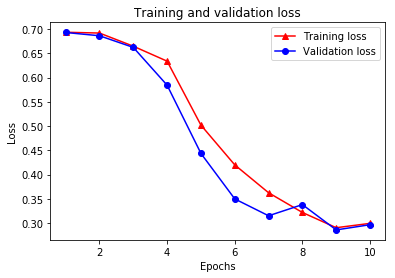

In [138]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

In [127]:
def create_example(word_vector, label, record_id):
    """Create tf.Example containing the sample's word vector, label, and ID."""
    features = {
      'id': _bytes_feature(str(record_id)),
      'words': _int64_feature(np.asarray(word_vector)),
      'label': _int64_feature(np.asarray([label])),
    }
    return tf.train.Example(features=tf.train.Features(feature=features))

def create_records(word_vectors, labels, record_path, starting_record_id):
    record_id = int(starting_record_id)
    with tf.io.TFRecordWriter(record_path) as writer:
        for word_vector, label in zip(word_vectors, labels):
            example = create_example(word_vector, label, record_id)
            record_id = record_id + 1
            writer.write(example.SerializeToString())
    return record_id

# Persist TF.Example features (word vectors and labels) for training and test
# data in TFRecord format.
next_record_id = create_records(pp_train_data, pp_train_labels,
                                '/tmp/imdb/train_data.tfr', 0)
create_records(pp_test_data, pp_test_labels, '/tmp/imdb/test_data.tfr',
               next_record_id)

50000

In [ ]:
class HParams(object):
    def __init__(self):
        self.input_shape = [28, 28, 1]
        self.num_classes = 10
        self.conv_filters = [32, 64, 64]
        self.kernel_size = (3, 3)
        self.pool_size = (2, 2)
        self.num_fc_units = [64]
        self.batch_size = 32
        self.epochs = 5
        self.adv_multiplier = 0.2
        self.adv_step_size = 0.2
        self.adv_grad_norm = 'infinity'

HPARAMS = HParams()

datasets = tfds.load('mnist')

train_dataset = datasets['train']
test_dataset = datasets['test']

IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'

def normalize(features):
    features[IMAGE_INPUT_NAME] = tf.cast(
        features[IMAGE_INPUT_NAME], dtype=tf.float32) / 255.0
    return features

def convert_to_tuples(features):
    return features[IMAGE_INPUT_NAME], features[LABEL_INPUT_NAME]

def convert_to_dictionaries(image, label):
    return {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label}

train_dataset = train_dataset.map(normalize).shuffle(10000).batch(HPARAMS.batch_size).map(convert_to_tuples)
test_dataset = test_dataset.map(normalize).batch(HPARAMS.batch_size).map(convert_to_tuples)

def build_base_model(hparams):
    """Builds a model according to the architecture defined in `hparams`."""
    inputs = tf.keras.Input(shape=hparams.input_shape, dtype=tf.float32, name=IMAGE_INPUT_NAME)

    x = inputs
    
    for i, num_filters in enumerate(hparams.conv_filters):
        x = tf.keras.layers.Conv2D(num_filters, hparams.kernel_size, activation='relu')(x)
        if i < len(hparams.conv_filters) - 1:
            # max pooling between convolutional layers
            x = tf.keras.layers.MaxPooling2D(hparams.pool_size)(x)
    x = tf.keras.layers.Flatten()(x)
    
    for num_units in hparams.num_fc_units:
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)
        
    pred = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=pred)
    
    return model

adv_config = nsl.configs.make_adv_reg_config(
    multiplier=HPARAMS.adv_multiplier,
    adv_step_size=HPARAMS.adv_step_size,
    adv_grad_norm=HPARAMS.adv_grad_norm
)

base_adv_model = build_base_model(HPARAMS)
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config
)

train_set_for_adv_model = train_dataset.map(convert_to_dictionaries)
test_set_for_adv_model = test_dataset.map(convert_to_dictionaries)

adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
adv_model.fit(train_set_for_adv_model, epochs=HPARAMS.epochs)